Эксперимент на пользователях в течение 2 недель. В результаты мы получили сырые данные об эксперименте, которые нам надо обработать и сделать выводы. 

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# загрузим данные и посмотрим на них
views = pd.read_csv('views.csv')
likes = pd.read_csv('likes.csv')

In [4]:
views.head(3)

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825


In [6]:
likes.head(3)

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828


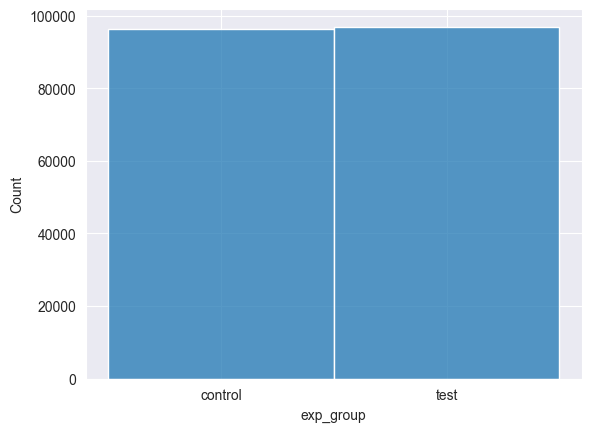

In [10]:
sns.set_style("darkgrid")
sns.histplot(views.exp_group)
plt.show()

Так как у нас нет таблицы соответствия пользователь-групппа, то нам необходимо убедлится в консистентности разбиения пользователей на группы

In [12]:
cons = views.groupby('user_id').exp_group.nunique().reset_index()
cons[cons.exp_group > 1]

,user_id,exp_group
10071,25623,2
20633,55788,2
54475,142283,2
57065,148670,2


Видим, что есть 4 пользователя сразу находящихся сразу в двух группах. Удалим их из выборки

In [14]:
users_to_remove = cons[cons.exp_group > 1].user_id.values

views = views[~np.in1d(views.user_id, users_to_remove)]
likes = likes[~np.in1d(likes.user_id, users_to_remove)]

In [15]:
views.groupby('user_id').first().exp_group.value_counts()

test       32659
control    32350
Name: exp_group, dtype: int64

Проведём бином тест, чтобы убедиться, что группы разбиты нормально (хотя график и внушает доверие)

In [16]:
from scipy.stats import binomtest

binomtest(k=32659, n=32659+32350, p=0.5)

BinomTestResult(k=32659, n=65009, alternative='two-sided', statistic=0.5023765940100602, pvalue=0.2270501563614752)


pvalue=0.227 из чего принимаем нулевую гипотезу о том, что выборки не различаются

Посмотрим какая часть пользователей поставила хотя бы одну реакцию за время проведения эксперимента

In [19]:
groups = views.groupby('user_id').first().reset_index()[['user_id', 'exp_group']]
groups.sample(3)

,user_id,exp_group
17268,45992,control
31343,82791,test
59842,155571,test


In [22]:
likes_per_user = (
    likes
    .groupby('user_id')
    .post_id.count()
    .reset_index()
    .rename(columns={'post_id': 'like_num'})
)
likes_per_user.sample(3)

,user_id,like_num
41126,120967,3
38331,113101,1
38071,112309,7


In [51]:
percentage_of_likers = 1 - (len(views.user_id.unique()) - len(likes_per_user)) / len(views.user_id.unique())
print(f"Хотя бы 1 лайк в ходе эксперимента поставило: {round(percentage_of_likers, 4)*100}% пользователей")


Хотя бы 1 лайк в ходе эксперимента поставило: 89.48% пользователей


In [62]:
user_likes = pd.merge(groups, likes_per_user, on='user_id', how='left')
user_likes.like_num = user_likes.like_num.fillna(0)
user_likes['has_like'] = (user_likes['like_num'] > 0).astype(int)
user_likes.head(3)

,user_id,exp_group,like_num,has_like
0,200,test,1.0,1
1,201,test,3.0,1
2,202,test,2.0,1


In [63]:
likes_per_user_grouped = user_likes.groupby('exp_group')[['has_like', 'like_num']].mean()
likes_per_user_grouped.rename(columns={'like_num': 'avg_like_num'})

,has_like,avg_like_num
exp_group,,
control,0.891314,3.487079
test,0.898160,3.592578


Проверим доли пользователей с хотя бы одним лайком и число лайков на пользователя

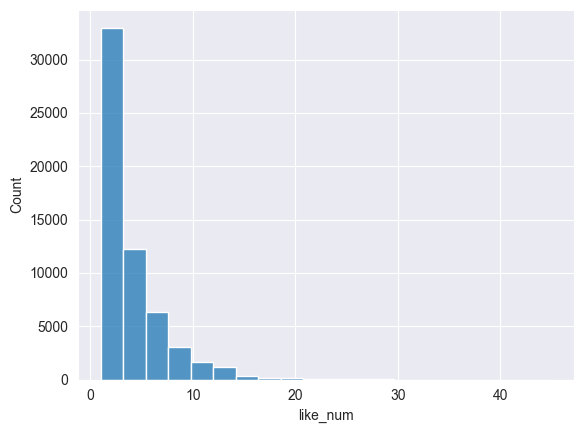

In [75]:
sns.histplot(likes_per_user.like_num, bins=20)
plt.show()

У нас логнормальное распределение. Воспользумся критерием Манна-Уитни-Уилкоксона

In [65]:
from scipy.stats import mannwhitneyu

mannwhitneyu(
    user_likes[user_likes.exp_group == 'control'].like_num,
    user_likes[user_likes.exp_group == 'test'].like_num,
)

MannwhitneyuResult(statistic=518358073.0, pvalue=2.958506279244197e-05)

pvalue=2.96E-5 а значит, что изменения значимые

Посчитаем hitrate. У нас нет айди по которому можно сджойнить, поэтому сделаим джомн по пользователям всех лайков и всех показов рекомендаций. Отфильтруем по времени показ от лайка (возьмём за отсечку 1 час)

In [82]:
pivot = pd.merge(views, likes, on='user_id', how='outer')
pivot.post_id = pivot.post_id.fillna(-1).astype(int)
pivot.head(3)

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,[3644 4529 4704 5294 4808],1654030803,4704,1.654031e+09
1,128381,control,[3644 4529 4704 5294 4808],1654030803,5294,1.654031e+09
2,128381,control,[3644 4529 4704 5294 4808],1654030803,3608,1.655049e+09


In [83]:
pivot['recommendations'] = pivot.recommendations.apply(
    lambda x: list(map(int, filter(bool, x[1:-1].split(' '))))
)
pivot.head(3)

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4704,1.654031e+09
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,5294,1.654031e+09
2,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,3608,1.655049e+09


In [84]:
# Пробежимся по всем показам и сравним с лайками. 
# Пометим то, слишком старое или из будущего, лайки по непоказанным рекомендациям
pivot.post_id = pivot.apply(
    lambda row:
    -1
    if
        (row.post_id == -1) | 
        ((row.timestamp_x > row.timestamp_y) |
         (row.timestamp_x + 60 * 60 < row.timestamp_y)) |
        (row.post_id not in row.recommendations)
    else
    row.post_id, axis=1)

In [86]:
def my_agg(values):
    values = set(values)
    if -1 in values and len(values) >= 2:
        return 1
    elif -1 not in values:
        return 1
    return 0

agg = pivot.groupby(['user_id', 'exp_group', 'timestamp_x']).post_id.agg(my_agg)
agg.reset_index().post_id.mean()

0.7132582734855227

Доля показов рекомендованных постом с хотя бы одним лайком: 71.33%

Оценим различие между группами и значимость. Применим бакетный подход, уровень значимости 0.05.

In [89]:
agg = agg.reset_index().rename(columns={'post_id': 'hitrate'})

In [90]:
import hashlib
# разбиваем на бакеты
agg['bucket'] = agg['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'bbb').encode()).hexdigest(), 16) % 100
)

In [93]:
agg.sample(3)

,user_id,exp_group,timestamp_x,hitrate,bucket
157333,138163,test,1654727173,1,5
139915,123572,test,1654231745,1,28
143409,126600,test,1654413995,0,61


In [94]:
agg['view'] = 1

new_df = agg.groupby(['exp_group', 'bucket']).sum(['hitrate', 'view']).reset_index()
new_df['hitrate_new'] = new_df.hitrate / new_df.view

new_df.head(3)

,exp_group,bucket,user_id,timestamp_x,hitrate,view,hitrate_new
0,control,0,75055655,1472627637383,621,890,0.697753
1,control,1,78264361,1557009869357,666,941,0.707758
2,control,2,89756485,1664574067853,705,1006,0.700795


In [95]:
# считаем метрику
agg.groupby('exp_group').hitrate.mean()

exp_group
control    0.706651
test       0.719829
Name: hitrate, dtype: float64

Разница почти в 2 процента. Оценим значимость

In [96]:
from scipy.stats import ttest_ind

In [97]:
mannwhitneyu(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

MannwhitneyuResult(statistic=2474.0, pvalue=6.795052834951048e-10)

In [98]:
ttest_ind(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

Ttest_indResult(statistic=-6.283293948472979, pvalue=2.0664050599155474e-09)

pvalue в обоих тестах показывает, что мы можем отклонить нудевую гипотезу о том, что модели рекомендует одинаково. Изменение значимое